In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
from allison.nn.layers import Relu,Linear
from allison.nn.optim import SGDMomentum
from allison.nn.tensor import Tensor,no_grad
from allison.nn.net import NeuralNetwork
from allison.nn.loss import  MSELoss
from allison.utils.functions.data import train_test_split
from allison.nn.scores import r2_score
import pandas as pd

# Datos

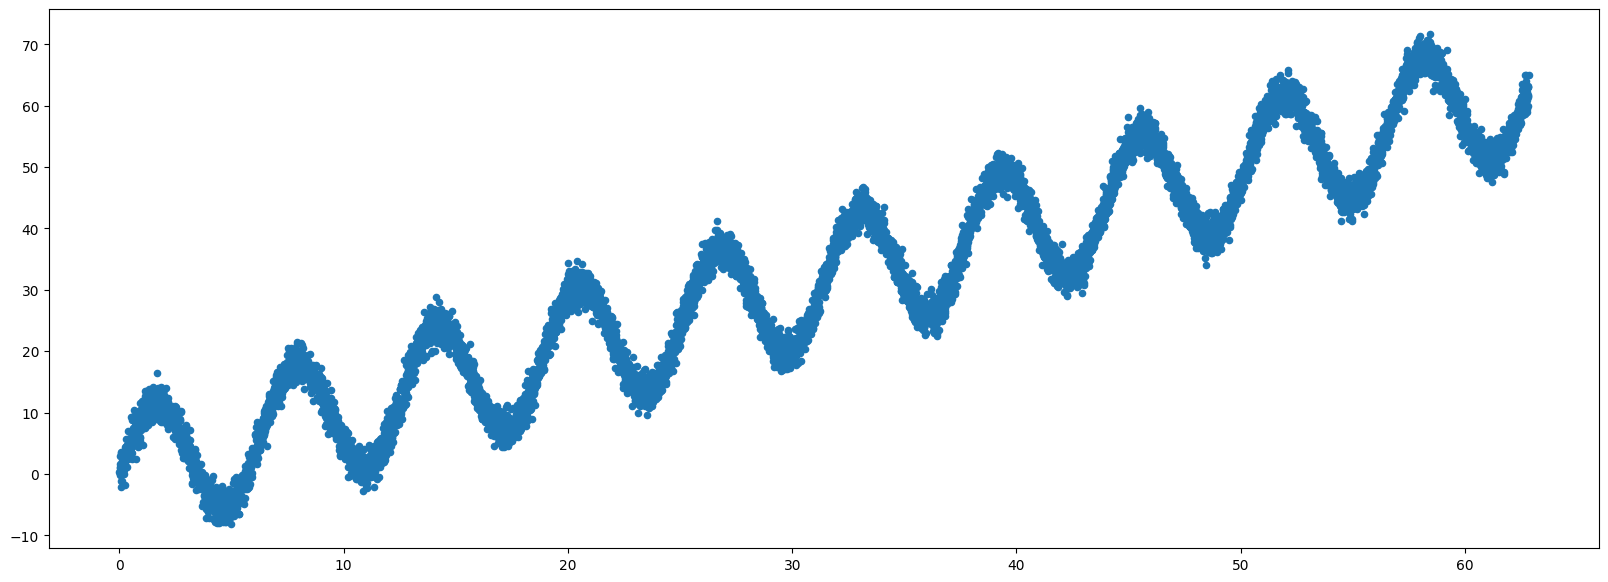

In [41]:
# Datos
points = 10000
x1 = np.linspace(0, 20*np.pi, points)
x2 = np.linspace(0, 20*np.pi, points)

# Definimos la salida
y = 10*np.sin(x1) + x2 + 1.5*np.random.randn(points)


data = pd.DataFrame({'x1': x1, 'x2': x2, 'y': y})
data.head()

plt.figure(figsize=(20,7))
plt.scatter(data['x2'], data['y'], s=20)
plt.show()


# Preprocessing

x1    31.346951
x2    31.346951
y     31.323061
dtype: float64
x1    18.146549
x2    18.146549
y     18.960637
dtype: float64


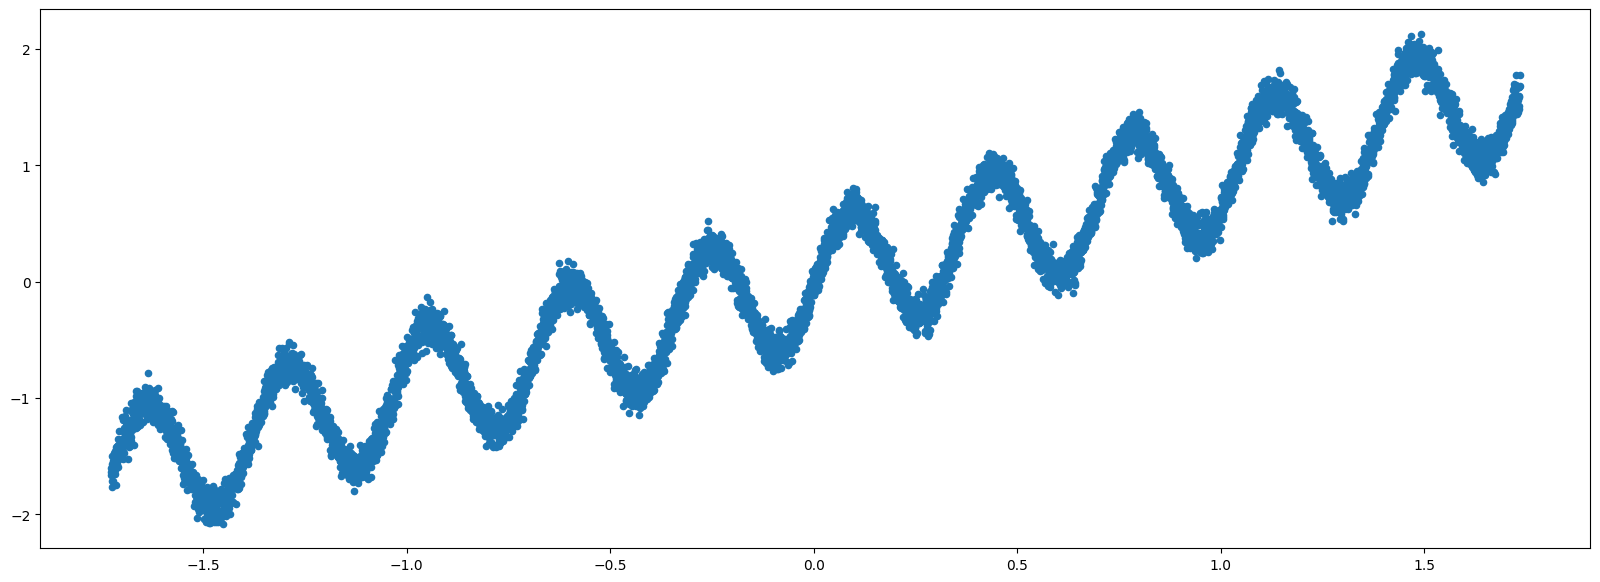

In [42]:
# Train test split and normalization

df_train, df_test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)


def_train_mean = df_train.mean()
def_train_std = df_train.std()

print(def_train_mean)
print(def_train_std)

df_train = (df_train-def_train_mean)/def_train_std
df_test = (df_test-def_train_mean)/def_train_std

plt.figure(figsize=(20,7))
plt.scatter(df_train['x2'], df_train['y'], s=20)
plt.show()


In [43]:
X_train = Tensor(df_train[['x1', 'x2']].values)
Y_train = Tensor(df_train[['y']].values)

X_test = Tensor(df_test[['x1', 'x2']].values)
Y_test = Tensor(df_test[['y']].values)


print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (8000, 2)
Y_train shape: (8000, 1)
X_test shape: (2000, 2)
Y_test shape: (2000, 1)


In [44]:
class Network(NeuralNetwork):
    def __init__(self):
        super().__init__()
        self.fc1 = Linear(2, 64)
        self.relu = Relu()
        self.fc2 = Linear(64, 32)
        self.fc3 = Linear(32, 1)

    def forward(self, x: Tensor) -> Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x


net = Network()



criterion = MSELoss()
optimizer = SGDMomentum(net.parameters(), learning_rate=1e-3, momentum=0.9)


In [45]:

# %%
# Bucle de entrenamiento mejorado
for epoch in range(1000 + 1):
    Y_pred = net(X_train)
    loss = criterion(Y_train,Y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        r2 = r2_score(Y_train, Y_pred)
        print(f"Epoch {epoch} | Loss: {loss.data:.4f} | R2: {100*r2:.3f}%")
        if r2 > 0.99:  # Mejoramos el criterio de parada
            print(f"Entrenamiento completado en {epoch} epochs!")
            break

Epoch 0 | Loss: 2.6981 | R2: -169.842%
Epoch 100 | Loss: 0.1428 | R2: 85.718%
Epoch 200 | Loss: 0.1423 | R2: 85.771%
Epoch 300 | Loss: 0.1420 | R2: 85.797%
Epoch 400 | Loss: 0.1419 | R2: 85.813%
Epoch 500 | Loss: 0.1418 | R2: 85.823%
Epoch 600 | Loss: 0.1417 | R2: 85.830%
Epoch 700 | Loss: 0.1416 | R2: 85.836%
Epoch 800 | Loss: 0.1416 | R2: 85.840%
Epoch 900 | Loss: 0.1416 | R2: 85.843%
Epoch 1000 | Loss: 0.1415 | R2: 85.845%


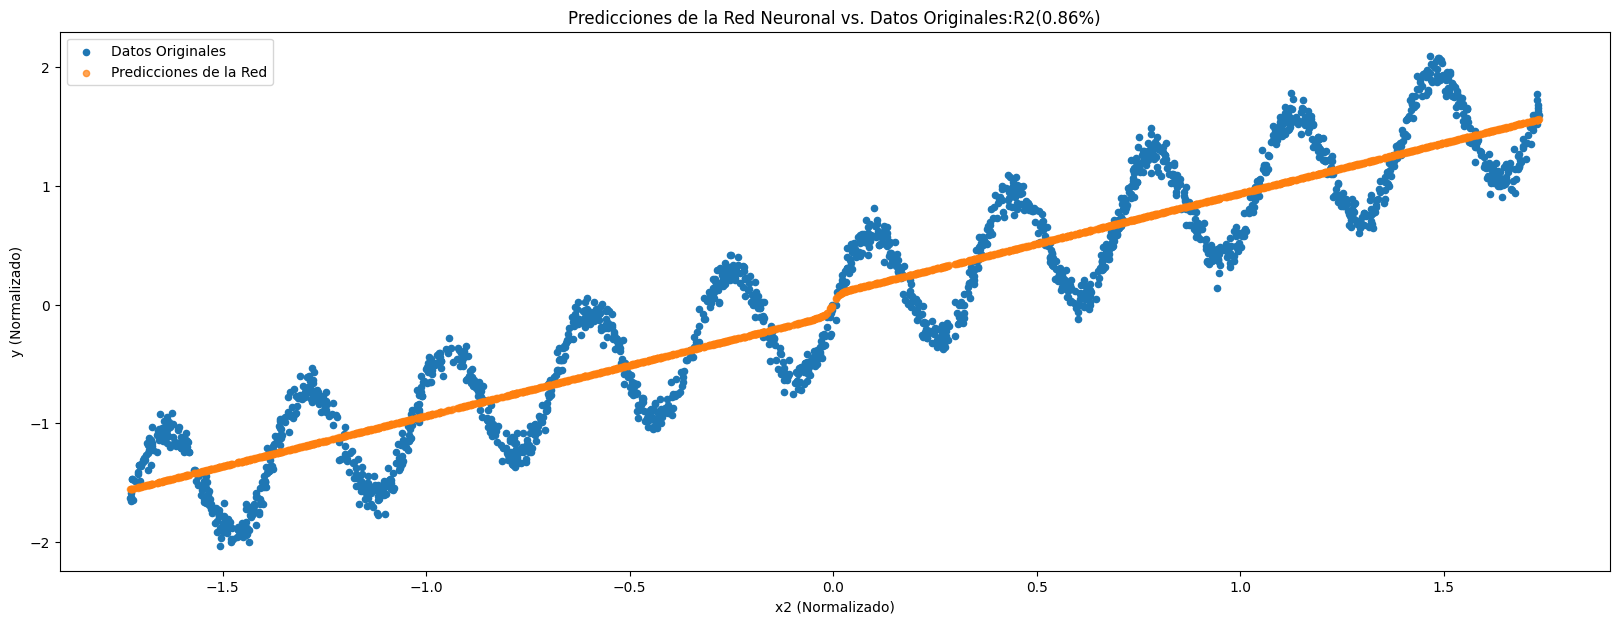

In [50]:
# %%
# Visualización final

with no_grad():
    y_pred = net(X_test)

r2 = r2_score(Y_test, y_pred)
plt.figure(figsize=(20, 7))
plt.scatter(X_test.data[:, 1], Y_test.data, label='Datos Originales', s=20)
plt.scatter(X_test.data[:, 1], y_pred.data, label='Predicciones de la Red', s=20, alpha=0.7)
plt.title(f'Predicciones de la Red Neuronal vs. Datos Originales:R2({r2:.2f}%)')
plt.xlabel('x2 (Normalizado)')
plt.ylabel('y (Normalizado)')
plt.legend()
plt.show()


# Rescaling

In [55]:
print(y_pred.data)

[[-1.43832235]
 [ 0.75256919]
 [ 0.50524428]
 ...
 [ 0.20705751]
 [-1.30221875]
 [ 0.75933313]]


In [56]:
y_final = y_pred.data * def_train_std['y'] + def_train_mean['y']
y_final_rescaled = y_final.flatten()
print(y_final_rescaled)

[ 4.05155218 45.59225224 40.90281418 ... 35.24900306  6.63216325
 45.72050084]
